In [1]:
#Data structures
import pandas as pd
import numpy as np
import datetime as dt

#plotting
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#Statistics
import math
import scipy as sp
from sklearn import preprocessing, metrics
#Forecasting
import pyrenn as prn

### LM-Neural Network

https://www.sciencedirect.com/science/article/abs/pii/S0360544216315006 - LM-NN faster convergenace and architecture <br> 
http://cs229.stanford.edu/proj2013/229final.pdf  - for feature vector ideas <br>

θ1 Hour of the day <br>
θ2 Day of the week <br>
θ3 Xt−24, Power consumption at the same time of the previous day <br>
θ4 X24t−1, Power consumption t−1 <br>
θ5 X24t−2, Power consumption t−2 <br>
θ6 X24t−3, Power consumption t−3 <br>
θ7 ∆X2,1=X24t−2−X24t−1, Derivitive of power consumptiont−1 <br>
θ8 Arithmetic mean of the power consumption for the same time of the day for all previous days

#### Data setup

In [2]:
datapath='../data/IoTData.csv'
timestampcolumn = 'DATETIME'
df = pd.read_csv(datapath, index_col=False, parse_dates=[timestampcolumn])

In [ ]:
#run this cell to remove Monday 9AM
def monday_9_am(row, col_name=timestampcolumn):
    if row[col_name].weekday() == 0 and row[col_name].hour == 9:
        return np.nan
    else:
        return True

#removes monday 9 am data
df.loc[:, ('not_monday_9_am')] = df.apply(lambda row: monday_9_am(row), axis=1)
df = df.dropna()

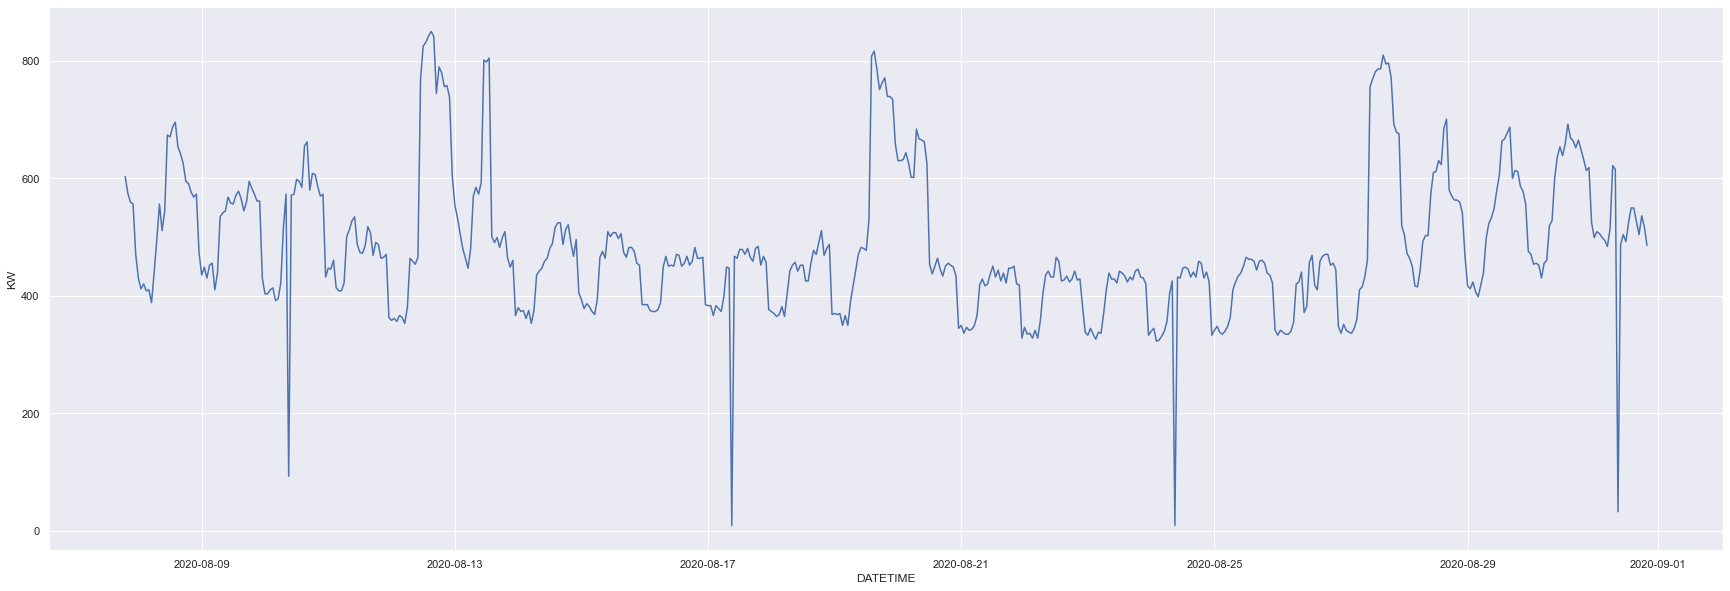

In [3]:
plot_size = (30, 10)
fig, ax = plt.subplots(figsize=plot_size)
sns.lineplot(x='DATETIME', y='KW', data=df[-24*24:])

In [4]:
feature_columns = ['DATETIME', 'KW', 'TEMP_AIR', 'KW_t-24', 'KW_t-24-1', 'KW_t-24-2', 'KW_t-24-3', 'TEMP_t-24', 'KW_sametime_mean_previous', 'KW_derivative_t-24','hour_of_day', 'day_of_week']

In [5]:
#helper functions
def exists_t_n(row, n, col_name, col_name_n):
    if row[col_name] - dt.timedelta(hours=n) == row[col_name_n]:
        return True
    else:
        return np.nan
    
def previous_day(df, time_col, time, ret_col, days=1):
    try:
        #iloc[0] makes empty series error out so we return np.nan
        return df[df[time_col] == time - dt.timedelta(days=days)].iloc[0][ret_col]
    except:
        if isinstance(ret_col, str):
            return np.nan
        else:
            return [np.nan] * len(ret_col)
        
def previous_sametime_mean(df, current_time, time_col):
    df_for_mean = df[df[time_col] < current_time]
    df_for_mean = df_for_mean[df_for_mean['hour_of_day'] == current_time.hour]
    return df_for_mean['KW'].mean()

In [6]:
#building features from original df
df_nn_ = df[['DATETIME', 'KW', 'TEMP_AIR', 'UMIDADE_REL']]
df_nn = df_nn_.loc[1:]

#1.a setup for features 3, 4, 5, 6
df_nn.loc[:, ('DATETIME_t-1')] = df_nn_['DATETIME'].shift(periods=1)
df_nn.loc[:, ('DATETIME_t-2')] = df_nn_['DATETIME'].shift(periods=2)
df_nn.loc[:, ('DATETIME_t-3')] = df_nn_['DATETIME'].shift(periods=3)
df_nn.loc[:, ('KW_t-1')] = df_nn_['KW'].shift(periods=1)
df_nn.loc[:, ('KW_t-2')] = df_nn_['KW'].shift(periods=2)
df_nn.loc[:, ('KW_t-3')] = df_nn_['KW'].shift(periods=3)
#1.b keeping only the data that has accompanying data for t-3, t-2, t-1 period
df_nn.loc[:, ('DATETIME_t-3_exists')] = df_nn.apply(lambda row: exists_t_n(row, 3, 'DATETIME', 'DATETIME_t-3'), axis=1)
df_nn.loc[:, ('DATETIME_t-2_exists')] = df_nn.apply(lambda row: exists_t_n(row, 2, 'DATETIME', 'DATETIME_t-2'), axis=1)
df_nn.loc[:, ('DATETIME_t-1_exists')] = df_nn.apply(lambda row: exists_t_n(row, 1, 'DATETIME', 'DATETIME_t-1'), axis=1)
df_nn = df_nn.dropna()

#2 building feature 1, 8
df_nn.loc[:, ('hour_of_day')] = df_nn.DATETIME.dt.hour
df_nn.loc[:, ('KW_sametime_mean')] = df_nn.groupby(['hour_of_day'])['KW'].transform(lambda x: x.mean())
df_nn.loc[:, ('KW_sametime_mean_previous')] = [previous_sametime_mean(df_nn, df_nn.iloc[i]['DATETIME'], 'DATETIME') for i in range(df_nn.shape[0])]
df_nn.dropna(inplace=True)
#3.a building feature 3, 4, 5, 6
df_nn.loc[:, ('KW_t-24', 'KW_t-24-1', 'KW_t-24-2', 'KW_t-24-3', 'TEMP_t-24')] =  [previous_day(df_nn, 'DATETIME', df_nn.iloc[i]['DATETIME'], ['KW', 'KW_t-1', 'KW_t-2', 'KW_t-3', 'TEMP_AIR']) for i in range(df_nn.shape[0])]
df_nn.dropna(inplace=True)

#4 building feature 7
df_nn.loc[:, ('KW_derivative_t-24')] = df_nn['KW_t-24-1'] - df_nn['KW_t-24-2']

#5 building feature 2
df_nn.loc[:, ('day_of_week')] = df_nn.DATETIME.dt.weekday

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [7]:
# 1. one hot encode hour of day
hour_categories = [f'hour_{n}' for n in range(24)]
enc = preprocessing.OneHotEncoder()
enc.fit(df_nn['hour_of_day'].values.reshape(-1,1))
a = enc.transform(df_nn['hour_of_day'].values.reshape(-1,1)).toarray()
df_nn.loc[:, tuple(hour_categories)] = a

# 2. one hot encode day of week
weekday_categories = [f'weekday_{n}' for n in range(7)]
enc.fit(df_nn['day_of_week'].values.reshape(-1,1))
a = enc.transform(df_nn['day_of_week'].values.reshape(-1,1)).toarray()
df_nn.loc[:, tuple(weekday_categories)] = a

In [ ]:
df_nn.to_csv('../data/BPfeatures.csv', index=False)

In [8]:
feature_columns.extend(hour_categories)
feature_columns.extend(weekday_categories)

In [9]:
df_nn_fin = df_nn[feature_columns]

In [10]:
df_nn_fin.head(5)

,DATETIME,KW,TEMP_AIR,KW_t-24,KW_t-24-1,KW_t-24-2,KW_t-24-3,TEMP_t-24,KW_sametime_mean_previous,KW_derivative_t-24,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
52,2019-09-17 10:00:00,740.88,29.4,488.88,8.40,485.52,451.92,26.9,491.40,-477.12,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53,2019-09-17 11:00:00,761.04,31.2,483.84,488.88,8.40,485.52,29.9,498.96,480.48,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
54,2019-09-17 12:00:00,792.96,32.5,455.28,483.84,488.88,8.40,32.6,490.56,-5.04,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55,2019-09-17 13:00:00,806.40,32.4,493.92,455.28,483.84,488.88,32.9,512.40,-28.56,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
56,2019-09-17 14:00:00,611.52,33.1,551.04,493.92,455.28,483.84,33.3,539.28,38.64,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
features = ['KW_t-24','KW_t-24-1', 'KW_t-24-2', 'KW_t-24-3', 'TEMP_AIR']
features.extend(hour_categories)
features.extend(weekday_categories)
predict_days = 24 * 5
train_up_to = df_nn.shape[0] - predict_days
X_train = df_nn[:train_up_to][features].T.to_numpy()
X_test = df_nn[:train_up_to]['KW'].values.reshape(-1, 1).T
Y_train = df_nn[train_up_to:][features].T.to_numpy()
Y_test = df_nn[train_up_to:]['KW'].values.reshape(-1, 1).T

In [12]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape, train_up_to, df_nn[:train_up_to].shape

((36, 7838), (1, 7838), (36, 120), (1, 120), 7838, (7838, 54))

#### NN model
8 inputs and 1 output
2 hidden layers, with 3 neurons each

In [13]:
#4,4 have good r2 score for 36 featuers
net = prn.CreateNN([X_train.shape[0],4,4,X_test.shape[0]])

In [14]:
%%time
net = prn.train_LM(X_train,X_test,net,verbose=True,k_max=100,E_stop=1e1)

Iteration:  0 		Error:  4657.623730241696 	scale factor:  3.0
Iteration:  1 		Error:  946.9508970167424 	scale factor:  0.3
Iteration:  2 		Error:  647.2440315649477 	scale factor:  0.03
Iteration:  3 		Error:  190.62787300128304 	scale factor:  0.003
Iteration:  4 		Error:  146.54030544094286 	scale factor:  0.03
Iteration:  5 		Error:  103.22833517173575 	scale factor:  0.003
Iteration:  6 		Error:  86.99870107724023 	scale factor:  0.3
Iteration:  7 		Error:  85.35237431673626 	scale factor:  0.03
Iteration:  8 		Error:  76.42109298973854 	scale factor:  0.03
Iteration:  9 		Error:  71.62771454428793 	scale factor:  0.3
Iteration:  10 		Error:  69.66039234007495 	scale factor:  0.3
Iteration:  11 		Error:  69.26705173022178 	scale factor:  0.3
Iteration:  12 		Error:  68.94837976054707 	scale factor:  0.3
Iteration:  13 		Error:  68.64550514833434 	scale factor:  0.3
Iteration:  14 		Error:  68.35155455749073 	scale factor:  0.3
Iteration:  15 		Error:  68.06747862533072 	scale fact

**all saved models path** <br>
features = ['KW_t-24','KW_t-24-1', 'KW_t-24-2', 'KW_t-24-3', 'TEMP_AIR']  hour + weekday one hot encoded
1. ../output/NN_forecast48hr_37features.csv + 'TEMP_t-24'
2. ../output/NN_forecast24hr_37features.csv + 'TEMP_t-24'
3. ../output/NN_forecast24hr_38features.csv + 'KW_sametime_mean_previous'
4. ../output/NN_forecast24hr_39features.csv + 'KW_derivative_t-24'
5. ../output/NN_forecast24hr_39features_5days.csv
6. ../output/NN_forecast24hr_36features_5days.csv
7. ../output/NN_forecast24hr_7features_5days.csv remove one hot encoding

In [15]:
save_nn_path = f'../output/NN_forecast24hr_36features_5days.csv'

In [16]:
prn.saveNN(net,save_nn_path)

In [ ]:
net_load = prn.loadNN(save_nn_path)

In [ ]:
plt.plot(net['ErrorHistory'][7:], label='Train Error')

#### Output analysis

In [ ]:
y = prn.NNOut(X_train,net)
ytest = prn.NNOut(Y_train,net)
print(
f'Training Output error analysis\n\
r2_score: {metrics.r2_score(X_test.T, y)} \n\
RMSE: {math.sqrt(metrics.mean_squared_error(X_test.T, y))} \n\
MAE: {metrics.mean_absolute_error(X_test.T, y)}'
)
print()
print(
f'Test Output error analysis\n\
r2_score: {metrics.r2_score(Y_test.T, ytest)} \n\
RMSE: {math.sqrt(metrics.mean_squared_error(Y_test.T, ytest))} \n\
MAE: {metrics.mean_absolute_error(Y_test.T, ytest)}'
)

In [ ]:
plot_train = pd.DataFrame(df_nn[:train_up_to]['DATETIME'].values, columns=['DATETIME'])
plot_train['predicted_KW'] = y
plot_train['actual_KW'] = X_test.T
plot_train.set_index('DATETIME', inplace=True)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(plot_train['actual_KW'], label="Actual")
plt.plot(plot_train['predicted_KW'], label="Prediction")
plt.legend(loc = 'best')

In [ ]:
plot_test = pd.DataFrame(df_nn[train_up_to:]['DATETIME'].values, columns=['DATETIME'])
plot_test['predicted_KW'] = ytest
plot_test['actual_KW'] = Y_test.T
plot_test['residuals'] = plot_test['actual_KW'] - plot_test['predicted_KW']
plot_test.set_index('DATETIME', inplace=True)

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(plot_test['actual_KW'], label="Test")
plt.plot(plot_test['predicted_KW'], label="Prediction")
plt.plot(plot_test['residuals'], label="residuals")
plt.legend(loc = 'best')

In [ ]:
print(
f"Residuals analysis \n\
min: {plot_test['residuals'].abs().min()}\n\
max: {plot_test['residuals'].abs().max()}\n\
mean: {plot_test['residuals'].abs().mean()}\
"
)

In [ ]:
#correlation between predicted and actual KW
plot_size = (5, 5)
sns.scatterplot(x='predicted_KW', y='actual_KW', data=plot_test)

In [ ]:
#Plotting everything together
plt.figure(figsize=(20,8))
plt.plot(plot_train['actual_KW'][-200:], label="Training")
plt.plot(plot_test['actual_KW'], label="Test")
plt.plot(plot_test['predicted_KW'], label="Prediction")
plt.plot(plot_test['residuals'], label="residuals")
plt.legend(loc = 'best')
plt.show()

In [ ]:
plot_test.describe()

In [ ]:
#there is one hour worth of energy usage difference
abs(plot_test['predicted_KW'].sum() - plot_test['actual_KW'].sum())

**Observations** <br>
Monday ridges are predicted when one hot encoding day and time. No ridges learnt without